# Imports

In [4]:
import csv

import numpy as np
import pandas as pd
import scipy.signal
import astropy.stats

#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
%matplotlib inline

# Constants

##### J1311 coords

PSR J1311-3430 -- Pulsar
Other object types:	gam (3EG,0FGL,...), Psr (PSR)
ICRS coord. (ep=J2000) :	13 11 50.2 -34 30 07 (Gamma-ray) [ 79200 79200 -20 ] E 2015ApJS..218...23A

[source](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=PSR%20J1311-34300)

In [5]:
# Physical constants
pi = 3.14159

In [6]:
# Plot text sizes
title_size = 24
axislabel_size = 22
axistick_size = 20

# File IO
- J1311 part 1 had error with additional 'E' inserted into line 40

##### Get file paths

In [7]:
file_directory = './data/J1311_photons/'
file_names = ['J1311_phase_part'+str(i)+'.txt' for i in range(1,6)]
print file_names
file_paths = [file_directory + file_name for file_name in file_names]
for file_path in file_paths:
    print file_path

['J1311_phase_part1.txt', 'J1311_phase_part2.txt', 'J1311_phase_part3.txt', 'J1311_phase_part4.txt', 'J1311_phase_part5.txt']
./data/J1311_photons/J1311_phase_part1.txt
./data/J1311_photons/J1311_phase_part2.txt
./data/J1311_photons/J1311_phase_part3.txt
./data/J1311_photons/J1311_phase_part4.txt
./data/J1311_photons/J1311_phase_part5.txt


##### Load pandas df

In [8]:
# Adjust the header to be pandas conformant
fh = open(file_paths[0])
header = ' '.join(fh.read().split('\n')[0].split()).split(' ')
header = [ele.replace('_', ' ') for ele in header]
print header
fh.close()

['ENERGY', 'RA', 'DEC', 'L', 'B', 'THETA', 'PHI', 'TIME', 'EVENT ID', 'PULSE PHASE']


In [9]:
df = pd.read_csv(file_paths[0], skiprows = [0], delimiter = ' ', header = None, names = header)

In [10]:
print len(df)

3036117


In [11]:
print df.dtypes

ENERGY         float64
RA             float64
DEC            float64
L              float64
B              float64
THETA          float64
PHI            float64
TIME           float64
EVENT ID         int64
PULSE PHASE    float64
dtype: object


In [12]:
df.head()

ENERGY        RA       DEC         L         B     THETA        PHI  \
0    117.8400  179.9646 -33.81308  290.8282  27.84342  58.71832  276.24650   
1    166.4942  179.7794 -36.94781  291.4443  24.75403  17.06174  297.73740   
2   1414.6280  179.9501 -35.99692  291.3597  25.71173  71.29970  349.51040   
3  12019.3700  179.7933 -35.63216  291.1318  26.03909  53.59599   75.80354   
4    176.3304  179.8074 -34.66773  290.9022  26.98145  53.96607  273.46490   

           TIME  EVENT ID  PULSE PHASE  
0  2.396096e+08   5314571     0.652637  
1  2.396105e+08   7254183     0.695484  
2  2.396118e+08  11024151     0.081871  
3  2.396165e+08   8917657     0.553284  
4  2.396555e+08   7993506     0.290104

# Preprocessing

##### Inspect columns

In [13]:
df.describe()

ENERGY            RA           DEC             L             B  \
count  3.036117e+06  3.036117e+06  3.036117e+06  3.036117e+06  3.036117e+06   
mean   4.577849e+02  1.980745e+02 -3.672175e+01  3.075376e+02  2.536689e+01   
std    2.385240e+03  9.292467e+00  6.910997e+00  8.317897e+00  6.869596e+00   
min    1.000002e+02  1.796602e+02 -4.948215e+01  2.906225e+02  1.320109e+01   
25%    1.491545e+02  1.905298e+02 -4.211773e+01  3.008781e+02  1.998093e+01   
50%    2.275397e+02  1.981240e+02 -3.755651e+01  3.075397e+02  2.439697e+01   
75%    4.067823e+02  2.056478e+02 -3.183432e+01  3.141646e+02  3.010335e+01   
max    2.991870e+05  2.162571e+02 -1.948332e+01  3.247774e+02  4.319901e+01   

              THETA           PHI          TIME      EVENT ID   PULSE PHASE  
count  3.036117e+06  3.036117e+06  3.036117e+06  3.036117e+06  3.036117e+06  
mean   5.544023e+01  1.541910e+02  2.730450e+08  7.433996e+06  4.997797e-01  
std    1.791595e+01  1.140567e+02  1.305799e+07  3.923373e+06  2.888203e-01  
min    4.602647e-02  1.244711e-04  2.395596e+08  9.740000e+02  0.000000e+00  
25%    4.197442e+01  5.434690e+01  2.653283e+08  4.718928e+06  2.495914e-01  
50%    6.347301e+01  1.346877e+02  2.751721e+08  7.612582e+06  4.996328e-01  
75%    6.850214e+01  2.635124e+02  2.835866e+08  1.016000e+07  7.498941e-01  
max    8.410781e+01  3.600000e+02  2.905634e+08  1.790765e+07  9.999995e-01

##### Sort in time, set t = 0 first measurement

In [14]:
df = df.sort_values('TIME')
min_time = np.min(df['TIME'].values)
df['TIME'] = df['TIME'].map(lambda x: x - min_time)

In [15]:
df.head()

ENERGY        RA       DEC         L         B     THETA       PHI  \
1748   129.4788  198.6116 -33.47010  308.4262  29.15602  52.74782  73.70184   
271    265.3268  202.1568 -25.31524  313.4409  36.79642  44.61626  69.53087   
1749  5017.9870  202.4359 -31.69188  312.3860  30.47565  49.34911  75.39683   
1311   385.9639  193.9431 -41.08589  303.8120  21.77841  61.48712  75.96196   
1046  1837.4280  202.0537 -22.68129  313.9317  39.40361  45.06182  64.35712   

         TIME  EVENT ID  PULSE PHASE  
1748   0.0000    163915     0.045586  
271    0.4536    165848     0.187222  
1749   0.9907    168078     0.939953  
1311  21.8511    254888     0.548622  
1046  65.9632    436869     0.664089

##### Adjust energy column
Mean photon energy is 457 eV (?), but the max is 299000... That doesn't seem right. Remove all photons that are too far outside of range. Compare the histogram before and after removing these points.

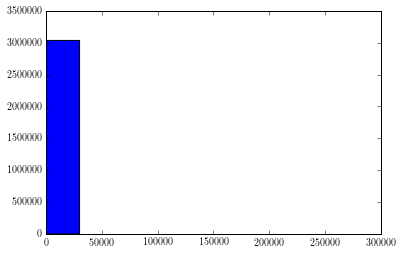

In [16]:
energy = df['ENERGY'].values
plt.hist(energy, bins = 10)
plt.show()

In [17]:
energy_cutoff = np.mean(energy) + 3*np.std(energy)
print energy_cutoff

7613.50314618


In [18]:
print len(df)
df = df[df['ENERGY'] < energy_cutoff]
print len(df)

3036117
3027379


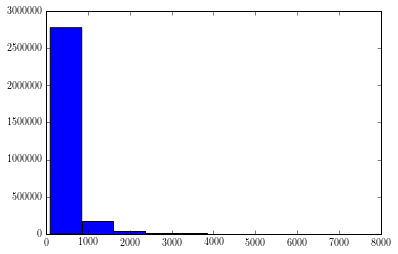

In [19]:
energy = df['ENERGY'].values
plt.hist(energy, bins = 10)
plt.show()

In [20]:
df.describe()

ENERGY            RA           DEC             L             B  \
count  3.027379e+06  3.027379e+06  3.027379e+06  3.027379e+06  3.027379e+06   
mean   3.868079e+02  1.980742e+02 -3.672333e+01  3.075372e+02  2.536528e+01   
std    5.230211e+02  9.293026e+00  6.909625e+00  8.318156e+00  6.868197e+00   
min    1.000002e+02  1.796602e+02 -4.948215e+01  2.906225e+02  1.320109e+01   
25%    1.489802e+02  1.905284e+02 -4.211755e+01  3.008771e+02  1.998094e+01   
50%    2.269374e+02  1.981235e+02 -3.755783e+01  3.075389e+02  2.439574e+01   
75%    4.041227e+02  2.056483e+02 -3.183808e+01  3.141649e+02  3.009964e+01   
max    7.613303e+03  2.162571e+02 -1.948332e+01  3.247774e+02  4.319901e+01   

              THETA           PHI          TIME      EVENT ID   PULSE PHASE  
count  3.027379e+06  3.027379e+06  3.027379e+06  3.027379e+06  3.027379e+06  
mean   5.546010e+01  1.541610e+02  3.349518e+07  7.435777e+06  4.997744e-01  
std    1.790765e+01  1.140561e+02  1.305187e+07  3.923071e+06  2.888222e-01  
min    4.602647e-02  1.244711e-04  0.000000e+00  9.740000e+02  0.000000e+00  
25%    4.200962e+01  5.432279e+01  2.578943e+07  4.722188e+06  2.495916e-01  
50%    6.348494e+01  1.346598e+02  3.561277e+07  7.614664e+06  4.996090e-01  
75%    6.851036e+01  2.634541e+02  4.402714e+07  1.016178e+07  7.498915e-01  
max    8.410781e+01  3.600000e+02  5.100380e+07  1.790765e+07  9.999995e-01

### Remove points outside of ROI

In [21]:
# Get the image matrix
ra = df['RA'].values
dec = df['DEC'].values
log_energy = np.log(df['ENERGY'].values)

ra_bins = np.linspace(np.min(ra), np.max(ra), 1024)

dec_bins = np.linspace(np.min(dec), np.max(dec), 1024)

ra_binned = np.digitize(ra, ra_bins) - 1
dec_binned = np.digitize(dec, dec_bins) - 1

dec_ra_matrix = np.zeros((dec_bins.shape[0], ra_bins.shape[0]))

for i in range(len(df)):
    dec_ra_matrix[dec_binned[i], ra_binned[i]] += 1

In [22]:
# Define the ROI ellipse
ra_center = (df['RA'].max() + df['RA'].min())/2.
dec_center = (df['DEC'].max() + df['DEC'].min())/2. 
a = 0.25
b = 0.25

thetas = np.linspace(0, 2*pi, 100)
ras = np.digitize(ra_center + a*np.cos(thetas), ra_bins)
decs = np.digitize(dec_center + b*np.sin(thetas), dec_bins)

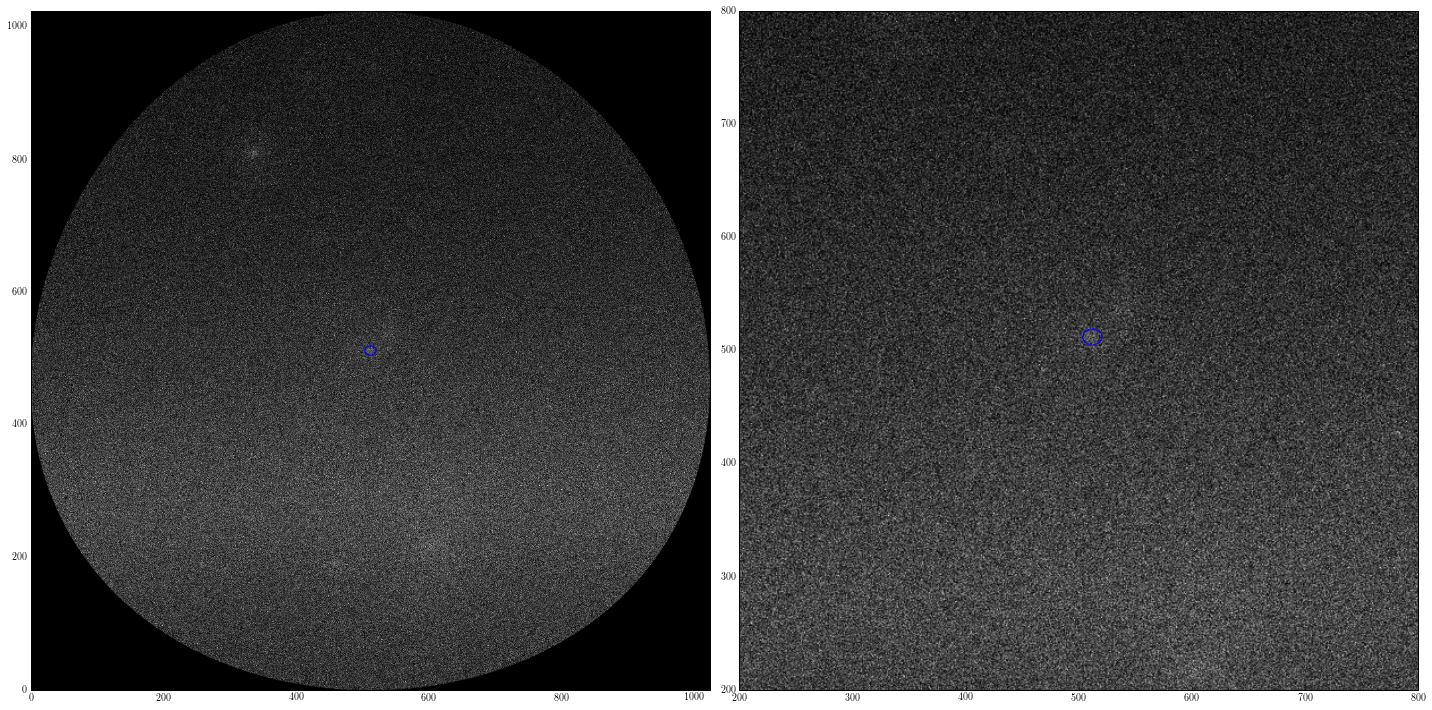

In [23]:
# Plot matrix and ROI ellipse
fig, ax = plt.subplots(1, 2, figsize = (20,10))

fig.sca(ax[0])
plt.imshow(dec_ra_matrix, cmap = 'gray', origin = 'lower left')
plt.plot(decs, ras)

plt.xlim(0, dec_ra_matrix.shape[0])
plt.ylim(0, dec_ra_matrix.shape[0])



fig.sca(ax[1])
plt.imshow(dec_ra_matrix, cmap = 'gray', origin = 'lower left')
plt.plot(decs, ras)


plt.xlim(200,800)
plt.ylim(200,800)

fig.tight_layout()

plt.show()

In [24]:
mod_df = df[df['RA'].map(lambda x: (x-ra_center)**2.)/a**2.+df['DEC'].map(lambda y: (y-dec_center)**2.)/b**2. <= 1]

In [25]:
print len(df)
print len(mod_df)

3027379
1052


##### Remove points within +/- $\phi$ ('on-phase' events)

In [26]:
mod_df['LOG ENERGY'] = mod_df['ENERGY'].map(lambda x: np.log(x))
energy_bins = np.linspace(mod_df['LOG ENERGY'].min(), mod_df['LOG ENERGY'].max(), 10)
print energy_bins

[ 4.60939027  5.07819847  5.54700667  6.01581486  6.48462306  6.95343126
  7.42223946  7.89104766  8.35985586  8.82866405]


/home/preston/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
energy_binned = np.digitize(mod_df['LOG ENERGY'], energy_bins)
print energy_binned

[7 2 1 ..., 9 1 5]


In [28]:
mod_df['ENERGY BIN'] = energy_binned

/home/preston/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
mod_df.head()

ENERGY        RA       DEC         L         B     THETA       PHI  \
1935   1879.3190  198.0977 -34.59165  307.8192  28.08114  64.10896  112.0353   
14944   255.1198  197.9826 -34.65260  307.7060  28.02907  30.40686  270.8684   
15004   144.1801  198.0026 -34.27501  307.7634  28.40363  44.67671  103.1188   
15335   572.4815  198.0644 -34.33950  307.8145  28.33475  25.35296  346.8973   
15394  3338.0480  197.7674 -34.53710  307.5175  28.15974  26.87646  291.8073   

              TIME  EVENT ID  PULSE PHASE  LOG ENERGY  ENERGY BIN  
1935   102046.2433   7581056     0.428791    7.538665           7  
14944  228672.1141   8865543     0.307896    5.541733           2  
15004  246089.4414   1845460     0.996346    4.971063           1  
15335  384142.7562   9014788     0.334904    6.349980           4  
15394  400900.4561  10548065     0.411472    8.113141           8

In [30]:
mod_df[mod_df['ENERGY BIN'] == 1]['PULSE PHASE'].values

array([ 0.99634552,  0.31896973,  0.10343552,  0.40962219,  0.20667648,
        0.70799065,  0.13833809,  0.53391838,  0.23233795,  0.20343018,
        0.25449944,  0.15372086,  0.90040016,  0.50261497,  0.16698265,
        0.57112503,  0.4331646 ,  0.95079041,  0.93056679,  0.200634  ,
        0.03144073,  0.79483795,  0.49976921,  0.72581673,  0.39335442,
        0.4099102 ,  0.41551781,  0.83699226,  0.98880196,  0.71043396,
        0.65037155,  0.35404778,  0.40884972,  0.79434776,  0.46390915,
        0.35844994,  0.97392845,  0.94049263,  0.07377625,  0.12057495,
        0.17383766,  0.3866539 ,  0.38768578,  0.23166466,  0.35657883,
        0.32451248,  0.67586517,  0.17700195,  0.94321823,  0.03327942,
        0.23843956,  0.30840683,  0.53912926,  0.397686  ,  0.34724808,
        0.96307945,  0.69604683,  0.18104744,  0.67983055,  0.45522881,
        0.82587433,  0.95087624,  0.1389122 ,  0.13806152,  0.57437706,
        0.22672844,  0.04792213,  0.97832108,  0.79746437,  0.32

1


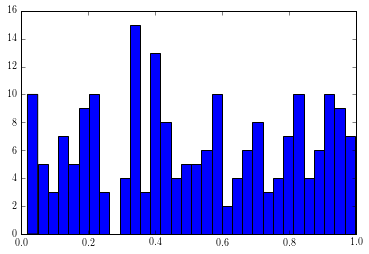

2


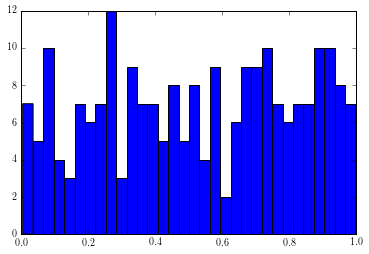

3


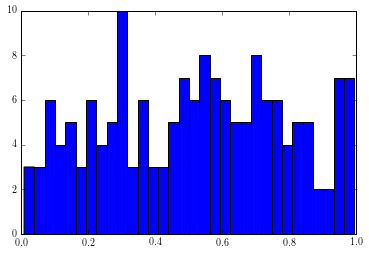

4


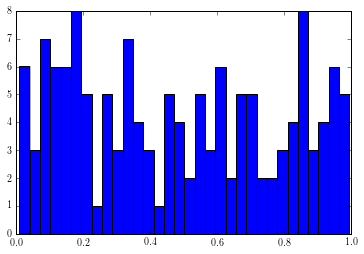

5


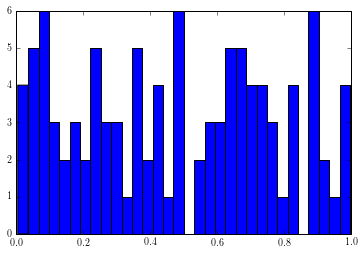

6


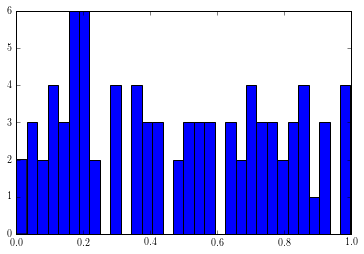

7


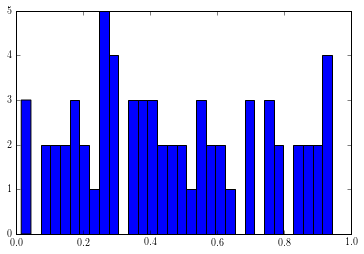

8


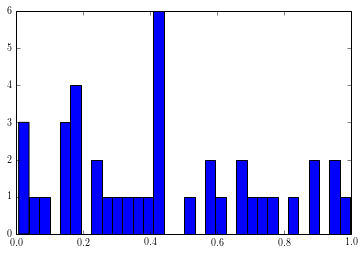

9


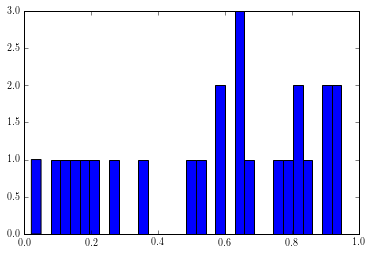

10


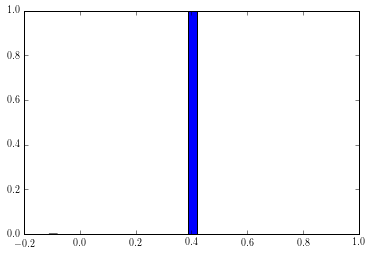

In [31]:
for energy_bin in range(1,11):
    print energy_bin
    plt.hist(mod_df[mod_df['ENERGY BIN'] == energy_bin]['PULSE PHASE'].values, bins = 32)
    plt.show()

phase_cutoff = .5
df = df[df['PULSE PHASE'] < phase_cutoff]

# Quick exploration

##### plot region of sky density

### Ra, Dec

In [90]:
ra = df['RA'].values
dec = df['DEC'].values

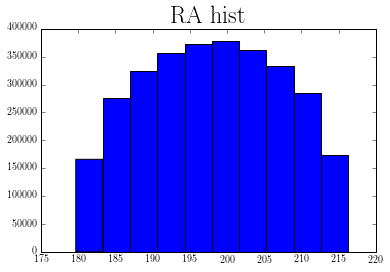

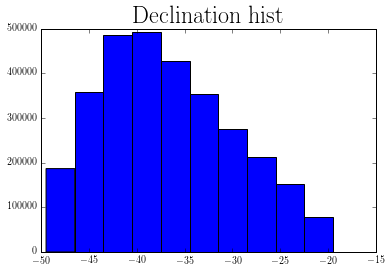

In [22]:
plt.hist(ra)

plt.title('RA hist', size = title_size)
plt.show()

plt.hist(dec)

plt.title('Declination hist', size = title_size)
plt.show()

In [91]:
ra_bins = np.linspace(np.min(ra), np.max(ra), 1000)
min_ra = np.min(ra)

dec_bins = np.linspace(np.min(dec), np.max(dec), 1000)
min_dec = np.min(dec)

ra_binned = np.digitize(ra, ra_bins) - 1
dec_binned = np.digitize(dec, dec_bins) - 1

dec_ra_matrix = np.zeros((dec_bins.shape[0], ra_bins.shape[0]))

for i in range(len(df)):
  dec_ra_matrix[dec_binned[i], ra_binned[i]] += 1

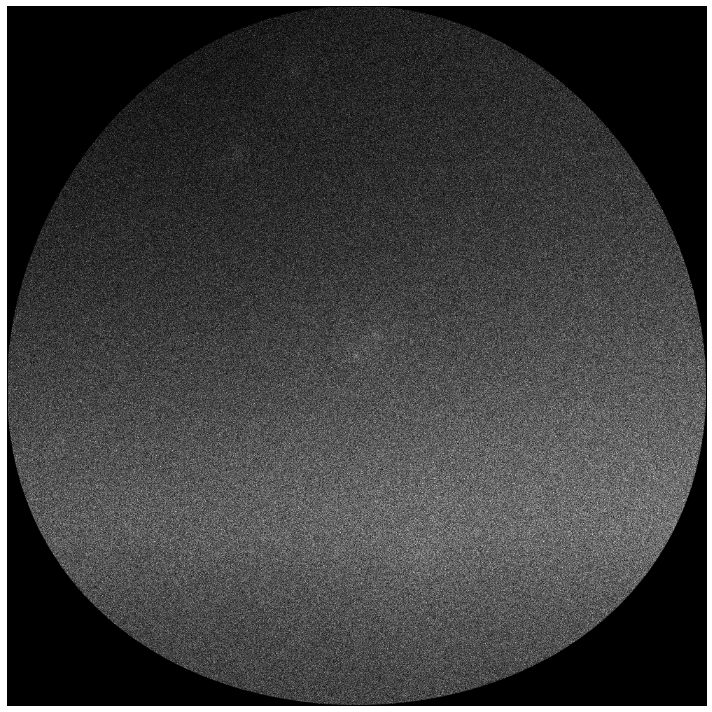

In [92]:
fig = plt.figure(figsize = (10,10))
plt.imshow(dec_ra_matrix, cmap = 'gray', origin = 'lower left')
plt.xticks([])
plt.yticks([])
fig.tight_layout()
#plt.savefig('J1311_photons_4.png', dpi = 300)
plt.show()

### L, B

In [61]:
L = df['L'].values
B = df['B'].values

L_bins = np.linspace(np.min(L), np.max(L), 1000)

B_bins = np.linspace(np.min(B), np.max(B), 1000)

L_binned = np.digitize(L, L_bins) - 1
B_binned = np.digitize(B, B_bins) - 1

L_B_matrix = np.zeros((L_bins.shape[0], B_bins.shape[0]))

for i in range(len(df)):
  L_B_matrix[L_binned[i], B_binned[i]] += 1

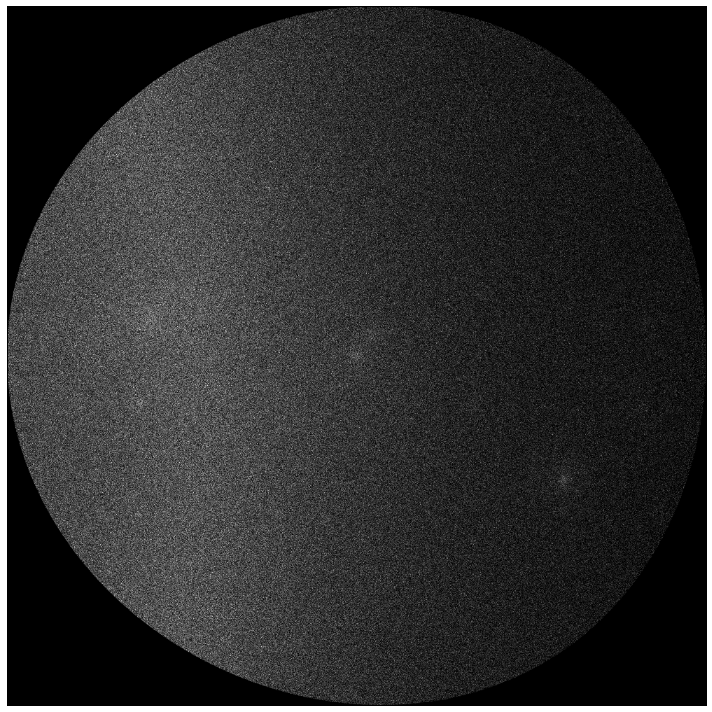

In [62]:
fig = plt.figure(figsize = (10,10))
plt.imshow(L_B_matrix, cmap = 'gray', origin = 'lower left')
plt.xticks([])
plt.yticks([])
fig.tight_layout()
#plt.savefig('J1311_photons_1.png', dpi = 300)
plt.show()

### $\theta$, $\phi$

In [59]:
theta = df['THETA'].values
phi = df['PHI'].values

theta_bins = np.linspace(np.min(theta), np.max(theta), 1000)

phi_bins = np.linspace(np.min(phi), np.max(phi), 1000)

theta_binned = np.digitize(theta, theta_bins) - 1
phi_binned = np.digitize(phi, phi_bins) - 1

theta_phi_matrix = np.zeros((theta_bins.shape[0], phi_bins.shape[0]))

for i in range(len(df)):
  theta_phi_matrix[theta_binned[i], phi_binned[i]] += 1

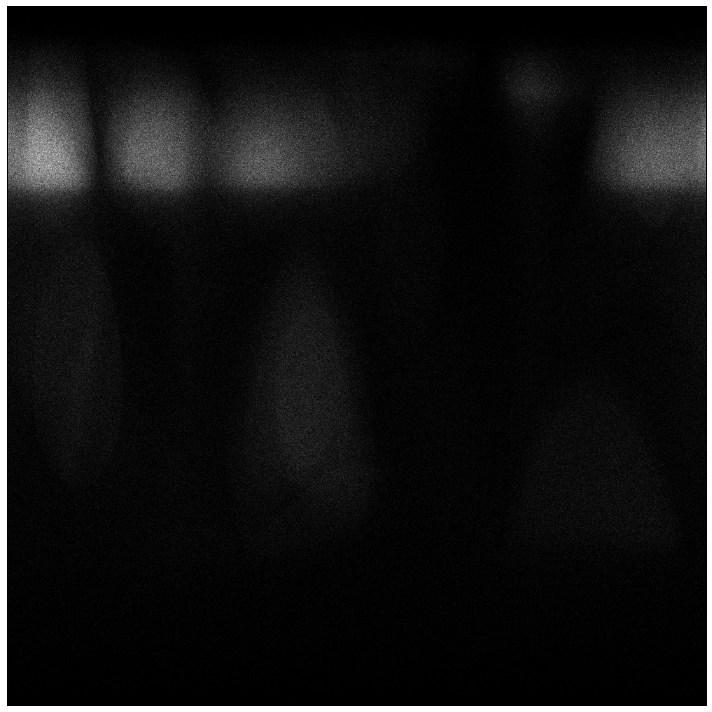

In [60]:
fig = plt.figure(figsize = (10,10))
plt.imshow(theta_phi_matrix, cmap = 'gray', origin = 'lower left')
plt.xticks([])
plt.yticks([])
fig.tight_layout()
#plt.savefig('J1311_photons_1.png', dpi = 300)
plt.show()

### plot phase vs. time

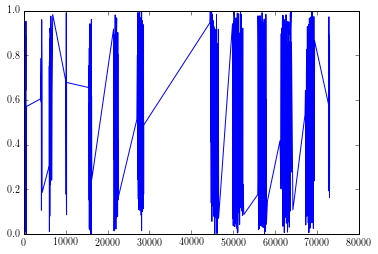

In [18]:
data = df[['TIME', 'PULSE PHASE']].values[:1000]

plt.plot(data[:,0], data[:,1])
plt.show()

##### Check the PSD of the PULSE PHASE to see if we can see the ms pulsar signal

In [40]:
orbital_freq = 1/(93.8*60)
print orbital_freq

0.000177683013504


In [41]:
data = df[['TIME', 'PULSE PHASE']].values[:100000]
freq, power = astropy.stats.LombScargle(data[:,0], data[:,1]).autopower()

In [42]:
print np.min(freq), np.max(freq)

2.06428302161e-08 0.0516070548973


In [43]:
min_freq = np.min(freq)
duration = 1./min_freq
print duration/(60*60*24)

560.682520417


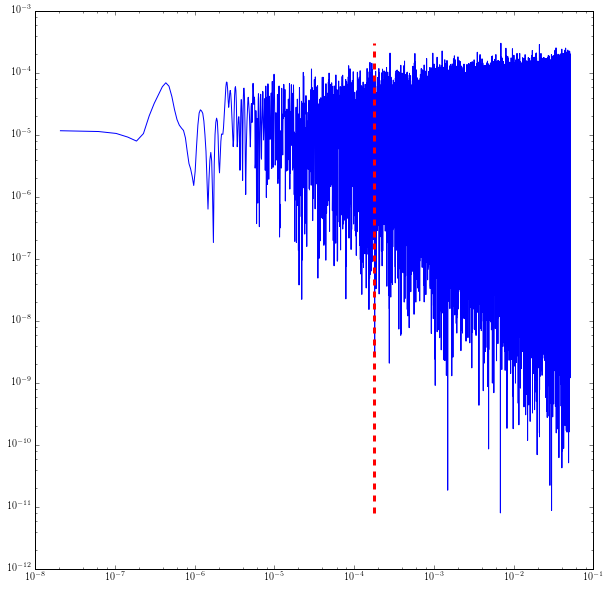

In [45]:
fig = plt.figure(figsize = (10,10))
plt.loglog(freq, power)
plt.plot([orbital_freq, orbital_freq], [np.min(power), np.max(power)], ls = '--', color = 'red', lw = 3)
plt.show()

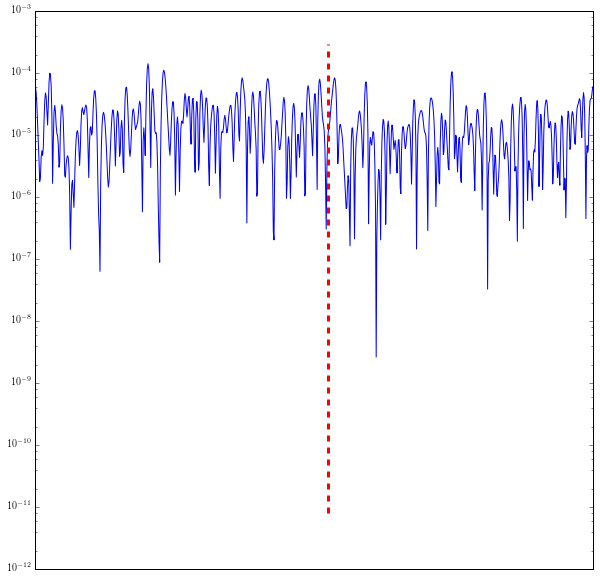

In [49]:
fig = plt.figure(figsize = (10,10))
plt.loglog(freq, power)
plt.plot([orbital_freq, orbital_freq], [np.min(power), np.max(power)], ls = '--', color = 'red', lw = 3)
plt.xlim(orbital_freq*.9, orbital_freq*1.1)
plt.show()